In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import keras

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Check if GPU is available
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Data Preprocessing and Labeling

In [3]:
video_directory = 'TRAIN_5'

sum = 0

gesture_folder = np.array(os.listdir(video_directory))
for gestures in gesture_folder:
    gesture = []

    for fname in os.listdir(os.path.join(video_directory, gestures)):
        path = os.path.join(video_directory, gestures, fname)
        if os.path.isdir(path):
            gesture.append(fname)

    sum += len(gesture) 
    # print(gestures, end =" : ")        
    # print(len(gesture))

print("Total gestures: ", len(gesture_folder), "; Total videos: ", sum)

Total gestures:  107 ; Total videos:  7098


In [4]:
print(gesture_folder)

['abang' 'ada' 'adik_lelaki' 'adik_perempuan' 'air' 'ambil' 'anak' 'apa'
 'arah' 'awak' 'ayah' 'baca' 'bagaimana' 'baik' 'baik2' 'bas' 'bawa'
 'belajar' 'beli' 'beli2' 'berapa' 'berjalan' 'berlari' 'bila' 'bola'
 'boleh' 'bomba' 'buang' 'buat' 'cuaca' 'curi' 'dapat' 'dari' 'datuk'
 'duit' 'esok' 'gambar' 'hari' 'hilang' 'hospital' 'hujan' 'ibu' 'jahat'
 'jalan' 'jam' 'jangan' 'jumpa' 'kacau' 'kafeteria' 'kakak' 'kedai'
 'keluarga' 'kereta' 'kereta_api' 'khabar_baik' 'lelaki' 'lupa' 'main'
 'makan' 'mana' 'marah' 'marah2' 'mari' 'mari2' 'masa' 'masalah'
 'menyakitkan' 'minum' 'mohon' 'mohon2' 'nama' 'nasi' 'nasi_lemak' 'nenek'
 'panas' 'panas2' 'pandai' 'pandai2' 'payung' 'pen' 'pensil' 'perempuan'
 'pergi' 'pergi2' 'perlahan' 'perlahan2' 'polis' 'pukul' 'ribut' 'sampai'
 'saudara' 'saya' 'sejuk' 'sekolah' 'selamat_pagi' 'siapa' 'sudah' 'suka'
 'tandas' 'tanya' 'teh_tarik' 'teksi' 'terima_kasih' 'tidur' 'tolong'
 'tolong2' 'waalaikumssalam']


In [5]:
label_map = {label: num for num, label in enumerate(gesture_folder)}
len(label_map)

107

In [ ]:
%%script false --no-raise-error
gesture_sequence, labels = [], []

for gestures in gesture_folder:
    gesture = []

    for fname in os.listdir(os.path.join(video_directory, gestures)):
        path = os.path.join(video_directory, gestures, fname)
        if os.path.isdir(path):
            gesture.append(fname)

    for no in gesture:
        load_path = os.path.join(video_directory, gestures, no)
        npy_files = sorted([f for f in os.listdir(load_path) if f.endswith('.npy')])
        npy_files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

        video = []
        for npy in npy_files:
            video.append(np.load(os.path.join(load_path, npy)))
        
        gesture_sequence.append(video)
        labels.append(label_map[gestures])

    # print(np.array(gesture_sequence).shape, np.array(labels).shape)

X = np.array(gesture_sequence)
y = np.array(labels)

np.save('X_TRAIN_5.npy', X)
np.save('y_TRAIN_5.npy', y)

In [8]:
X = np.load('train_numpy/train_5/X_TRAIN_5.npy')
y = np.load('train_numpy/train_5/y_TRAIN_5.npy')

print(X.shape, y.shape)

(7098, 30, 258) (7098,)


In [9]:
y = tf.keras.utils.to_categorical(y, num_classes=len(gesture_folder))
y.shape

(7098, 107)

In [10]:
y_labels = np.argmax(y, axis=1)

In [11]:
X_train_ori, X_test_ori, y_train_ori, y_test_ori = train_test_split(X, y, test_size=0.2, stratify=y_labels, random_state=42)

In [12]:
y_train_ori.shape, y_test_ori.shape

((5678, 107), (1420, 107))

### Train

In [13]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train_ori, dtype=torch.float32)
X_test = torch.tensor(X_test_ori, dtype=torch.float32)
y_train = torch.tensor(y_train_ori.argmax(axis=1), dtype=torch.long)  # Convert to class indices
y_test = torch.tensor(y_test_ori.argmax(axis=1), dtype=torch.long)  # Convert to class indices

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

# Define your custom LSTM model
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CustomLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, num_classes)
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = torch.relu(self.fc1(x[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.output_layer(x)
        return x

# Instantiate the model
input_size = 258
hidden_size = 64
num_classes = len(label_map)
model = CustomLSTM(input_size, hidden_size, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Train the model with early stopping
num_epochs = 10000
loss_history = []

# loss threshold
loss_threshold = 0.1

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()  # Reset gradients
        outputs = model(X_batch)  # Forward pass
        loss = criterion(outputs, y_batch)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        epoch_loss += loss.item() # Accumulate loss

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    if avg_loss < loss_threshold:
        print(f'Loss threshold of {loss_threshold} reached. Stopping training.')
        break

# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    accuracy = (test_outputs.argmax(dim=1) == y_test).float().mean()
    print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy.item():.4f}')

Epoch [1/10000], Loss: 4.5343
Epoch [2/10000], Loss: 4.0625
Epoch [3/10000], Loss: 3.9518
Epoch [4/10000], Loss: 3.7807
Epoch [5/10000], Loss: 3.5305
Epoch [6/10000], Loss: 3.3852
Epoch [7/10000], Loss: 3.3017
Epoch [8/10000], Loss: 3.2054
Epoch [9/10000], Loss: 3.1507
Epoch [10/10000], Loss: 3.1235
Epoch [11/10000], Loss: 3.1133
Epoch [12/10000], Loss: 2.9931
Epoch [13/10000], Loss: 2.9962
Epoch [14/10000], Loss: 2.8943
Epoch [15/10000], Loss: 2.8434
Epoch [16/10000], Loss: 2.8177
Epoch [17/10000], Loss: 2.7679
Epoch [18/10000], Loss: 2.7559
Epoch [19/10000], Loss: 2.7242
Epoch [20/10000], Loss: 2.6258
Epoch [21/10000], Loss: 2.6093
Epoch [22/10000], Loss: 2.5792
Epoch [23/10000], Loss: 2.5430
Epoch [24/10000], Loss: 2.5168
Epoch [25/10000], Loss: 2.4639
Epoch [26/10000], Loss: 2.4273
Epoch [27/10000], Loss: 2.5674
Epoch [28/10000], Loss: 2.4735
Epoch [29/10000], Loss: 2.3389
Epoch [30/10000], Loss: 2.2439
Epoch [31/10000], Loss: 2.1546
Epoch [32/10000], Loss: 2.1464
Epoch [33/10000],

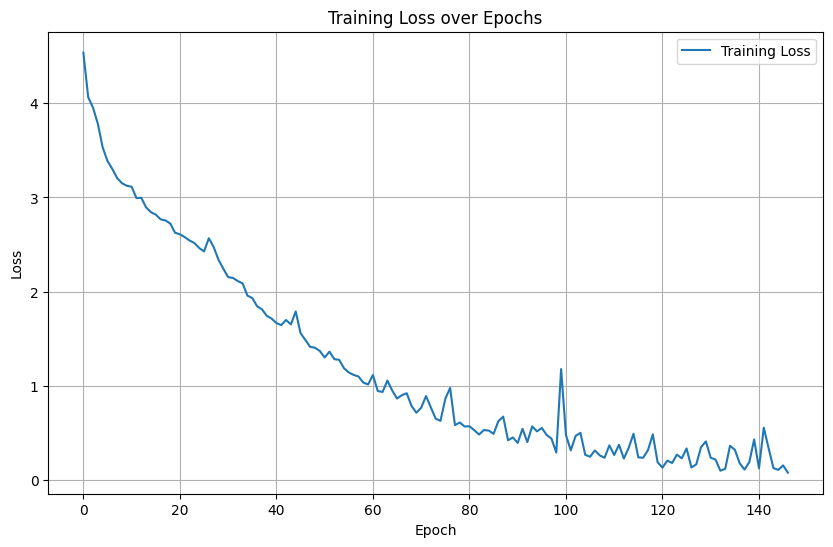

In [14]:
# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Save the trained model
model_filename = 'models/lstm_model_Train_5.pth'
torch.save(model.state_dict(), model_filename)
print(f"Model saved as {model_filename}")

Model saved as models/LSTM_model_Train_5.pth


### Prediction

In [50]:
# Define your custom LSTM model
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CustomLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, num_classes)
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = torch.relu(self.fc1(x[:, -1, :]))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.output_layer(x)
        return x
    
# Instantiate the model
input_size = 258
hidden_size = 64
num_classes = len(label_map)
model = CustomLSTM(input_size, hidden_size, num_classes)

# Load the saved model state dictionary
model_filename = 'models/lstm_model_Train_5_0.88.pth'
loaded_model_state_dict = torch.load(model_filename)

# Load the state dictionary into the model
model.load_state_dict(loaded_model_state_dict)
model.eval()  # Set the model to evaluation mode

# # Assuming you have X_test as a NumPy array
X_test_tensor = torch.tensor(X_test_ori, dtype=torch.float32)

# Now you can use the loaded model for prediction
# For example, you can pass your input data (X_test_tensor) through the model
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    predicted_classes = test_outputs.argmax(dim=1)

# predicted_classes now contains the predicted class indices for each input in X_test_tensor
print(predicted_classes)

C:\Users\MCYK\AppData\Local\Temp\ipykernel_19636\2466235969.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_state_dict = torch.load(model_filename)


tensor([22, 13, 63,  ..., 70, 45, 97])


In [51]:
res = model(X_test_tensor)
pred = res.argmax(dim=1)
print(res[0])
print(pred)

tensor([-130.8981,   11.0535, -132.9778,  -92.1378,  -46.6910,  -89.4248,
         -27.6455,   15.3879,  -17.0031,  -76.9909, -105.1833,   15.7702,
         -30.8651, -185.2094,  -76.8275,  -62.1716,   -8.0044,  -34.9898,
         -86.4443,  -62.6287, -141.5373,   -0.2650,   23.5584,    2.9288,
         -51.2891,  -59.8920,  -63.1364,  -32.0365,  -45.1787,  -83.1166,
         -25.0081,  -19.4400,   -8.4011, -125.6430,  -97.1018, -121.9073,
         -49.5082,  -34.1872,  -54.6381,  -47.8524,  -96.3181,  -59.8545,
         -88.8929,   -6.1731,  -37.9106,  -88.9640,  -29.8496,  -32.5698,
         -55.2154,  -98.3416,  -40.5800,  -53.0521,    5.1903,    8.5903,
          13.1013,  -51.5672, -129.7589,   -6.4127,  -56.2155, -136.6278,
         -48.8179, -112.8410,  -65.0966,  -79.0366,  -11.9255,   -0.6437,
         -35.2404,  -93.9025,  -70.8909,  -54.3128,  -14.2917, -148.6270,
         -41.0655,  -72.4493, -101.5379, -105.8285, -116.2042, -104.6264,
          -1.7340, -145.3926, -115.865

In [52]:
# Compare predicted classes with the ground truth labels
for i in range(len(y_test_ori)):
    print(f'Predicted: {gesture_folder[pred[i]]}, Actual: {gesture_folder[y_test_ori[i].argmax()]}')

Predicted: berlari, Actual: berlari
Predicted: baik, Actual: baik
Predicted: mari2, Actual: mari2
Predicted: menyakitkan, Actual: menyakitkan
Predicted: terima_kasih, Actual: terima_kasih
Predicted: awak, Actual: awak
Predicted: sejuk, Actual: sejuk
Predicted: keluarga, Actual: keluarga
Predicted: perlahan, Actual: perlahan
Predicted: bila, Actual: bila
Predicted: mana, Actual: mana
Predicted: kacau, Actual: kacau
Predicted: pensil, Actual: makan
Predicted: sudah, Actual: sudah
Predicted: jangan, Actual: jangan
Predicted: bas, Actual: duit
Predicted: bawa, Actual: bawa
Predicted: berlari, Actual: berlari
Predicted: minum, Actual: minum
Predicted: masalah, Actual: masalah
Predicted: bila, Actual: berjalan
Predicted: berapa, Actual: berapa
Predicted: nasi, Actual: nasi
Predicted: ayah, Actual: ayah
Predicted: mohon2, Actual: mohon2
Predicted: selamat_pagi, Actual: selamat_pagi
Predicted: berjalan, Actual: bila
Predicted: baik, Actual: baik
Predicted: curi, Actual: curi
Predicted: cuaca, 

In [53]:
# Test the model prediction
test_accuracy = (predicted_classes == y_test_ori.argmax(axis=1)).float().mean()
print(f'Test Accuracy: {test_accuracy.item():.4f}')


Test Accuracy: 0.8873


In [21]:
def load_keypoints(folder_path):
    """
    Load the keypoints from a given file path.
    
    Parameters:
    path (str): Path to the .npy file containing the keypoints.
    
    Returns:
    list of np.ndarray: List of frames where each frame is a numpy array representing keypoints.
    """
    frames_keypoints = []

    files = [f for f in os.listdir(folder_path) if f.endswith('.npy')]
    # print(files)

    # arrange files in ascending order
    files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    print(files)

    # Load the keypoints from the .npy file
    for file in files:
        file_path = os.path.join(folder_path, file)
        frame_keypoints = np.load(file_path)
        frames_keypoints.append(frame_keypoints)

    return frames_keypoints

In [ ]:
# %%script false
def normalize_keypoints(input_folder):
    '''
    - pose_keypoints: np.array of shape (33*4,), containing (x, y, z, visibility) for each of the 33 pose keypoints.
    - left_hand_keypoints: Optional, np.array of shape (21*3,), containing (x, y, z) for each of the 21 left hand keypoints.
    - right_hand_keypoints: Optional, np.array of shape (21*3,), containing (x, y, z) for each of the 21 right hand keypoints.
    '''

    # keypoint indices for should and nose
    LEFT_SHOULDER = 11
    RIGHT_SHOULDER = 12
    NOSE = 0

    # Define wrist indices in the hand keypoints
    LEFT_WRIST = 15
    RIGHT_WRIST = 16

    # Results array
    results = []
    
    npy_files = sorted([f for f in os.listdir(input_folder) if f.endswith('.npy')])
    npy_files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    for npy_file in npy_files:
        # load the keypoints
        keypoints = np.load(os.path.join(input_folder, npy_file))
        pose_keypoints = keypoints[:33*4]  # Extract pose keypoints
        left_hand_keypoints = keypoints[33*4:33*4+21*3]   # Extract left hand keypoints
        right_hand_keypoints = keypoints[33*4+21*3:]  # Extract right hand keypoints
        
        # Reshape pose into 33x4 array
        pose_keypoints = pose_keypoints.reshape(33, 4)

        # Extract (x, y) coordinates of the left and right shoulders
        left_shoulder = pose_keypoints[LEFT_SHOULDER, :2] # (x, y)
        right_shoulder = pose_keypoints[RIGHT_SHOULDER, :2] # (x, y)

        # Calculate neck as midpoint between left and right shoulders
        neck = (left_shoulder + right_shoulder) / 2.0

        # Extract (x, y) coordinates of the nose
        head = pose_keypoints[NOSE, :2]

        # Calculate the normalization factor (distance between neck and nose)
        norm_factor = np.linalg.norm(head - neck)

        # Avoid division by zero
        if norm_factor == 0:

            #set norm_factor to 1 if division by zero
            norm_factor = 1
            

        # Normalize pose keypoints (x_k, y_k)
        normalized_pose = np.copy(pose_keypoints)
        for k in range(33):
            normalized_pose[k, :2] = (pose_keypoints[k, :2] - neck) / norm_factor

        # reshape into 21x3 array
        left_hand_keypoints = left_hand_keypoints.reshape(21, 3)
        right_hand_keypoints = right_hand_keypoints.reshape(21, 3)

        # Get wrist coordinates
        left_wrist = pose_keypoints[LEFT_WRIST, :2] # (x, y)
        right_wrist = pose_keypoints[RIGHT_WRIST, :2] # (x, y)

        if np.all(left_hand_keypoints == 0.00000000e+00):
            # print(f"{npy_file} hand keypoints are all zeros")
            normalized_left = np.copy(left_hand_keypoints)
        else:
            normalized_left = np.copy(left_hand_keypoints)
            for k in range(21):
            # Align left hand to left wrist
                normalized_left[k, :2] = (left_hand_keypoints[k, :2] - left_hand_keypoints[0, :2]) / norm_factor + (left_wrist - neck) / norm_factor

        if np.all(right_hand_keypoints == 0.00000000e+00):
            # print(f"{npy_file} hand keypoints are all zeros")
            normalized_right = np.copy(right_hand_keypoints)
        else:
            normalized_right = np.copy(right_hand_keypoints)
            for k in range(21):
            # Align right hand to right wrist
                normalized_right[k, :2] = (right_hand_keypoints[k, :2] - right_hand_keypoints[0, :2]) / norm_factor + (right_wrist - neck) / norm_factor

        # Concatenate normalized pose and hand keypoints
        normalized_keypoints = np.concatenate([normalized_pose.flatten(), normalized_left.flatten(), normalized_right.flatten()])
        results.append(normalized_keypoints)

    # Return the normalized keypoints
    return results

In [56]:
# Test with a single video
# Load a single video

# test = load_keypoints('DATASET/ada/08/landmarks')
test = normalize_keypoints('DATASET/jahat/16/landmarks')
test = np.array(test)
test = np.expand_dims(test, axis=0)
test = torch.tensor(test, dtype=torch.float32)

# Make predictions
with torch.no_grad():
    test_outputs = model(test)
    predicted_class = test_outputs.argmax(dim=1)

# Convert the predicted class index to the corresponding gesture label
predicted_gesture = gesture_folder[predicted_class]
print(predicted_gesture)

jahat


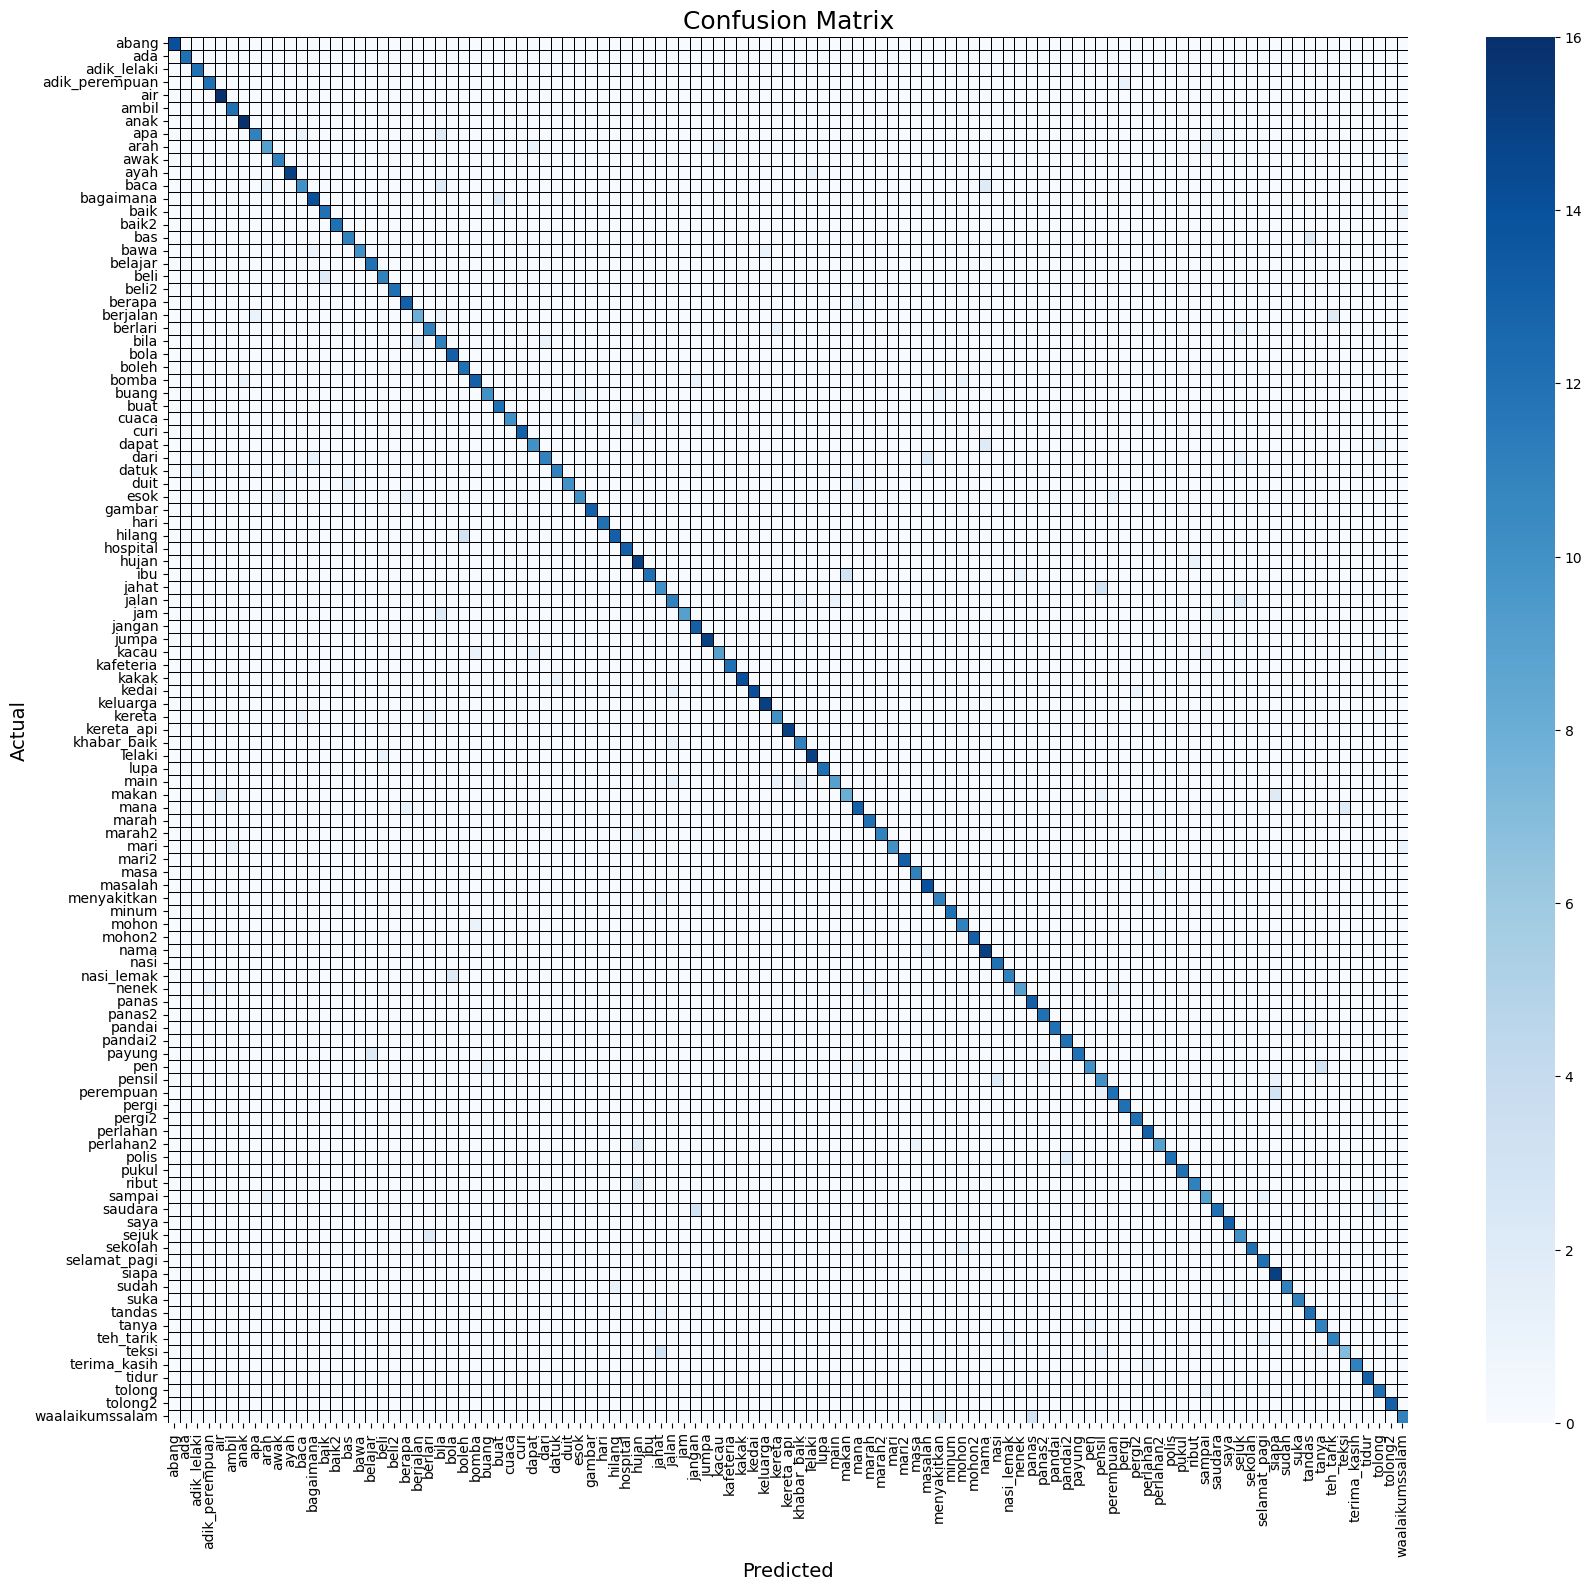

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        12
           2       0.92      1.00      0.96        12
           3       0.92      0.92      0.92        13
           4       0.89      1.00      0.94        16
           5       0.92      1.00      0.96        12
           6       0.94      1.00      0.97        16
           7       0.92      0.73      0.81        15
           8       0.82      0.75      0.78        12
           9       0.92      0.92      0.92        12
          10       0.94      0.94      0.94        16
          11       0.83      0.67      0.74        15
          12       0.88      0.88      0.88        16
          13       0.86      0.92      0.89        13
          14       1.00      1.00      1.00        12
          15       0.92      0.85      0.88        13
          16       1.00      0.83      0.91        12
    

In [23]:
# Convert one-hot encoded y to class indices if necessary
if len(y.shape) == 2:  # Check for one-hot encoding
    y_true = np.argmax(y_test_ori, axis=1)
else:
    y_true = y  # Already class indices

# Convert PyTorch tensor of predicted classes to NumPy array
y_pred = predicted_classes.numpy()

# Step 3: Generate Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred)

# Step 4: Display Confusion Matrix
plt.figure(figsize=(20, 18)) 
sns.heatmap(
    conf_matrix, 
    annot=False, 
    cmap="Blues", 
    xticklabels=list(label_map.keys()), 
    yticklabels=list(label_map.keys()), 
    linecolor='black',  # Grid color
    linewidths=0.5      # Grid line width
)
plt.title("Confusion Matrix", fontsize=18)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels for better fit
plt.yticks(fontsize=10)  # Adjust font size for y-axis labels
plt.show()

# Step 5: Print Classification Report
print("Classification Report:")
print(class_report)


In [54]:
# %%script false --no-raise-error
# Reverse the label_map dictionary to get num_to_label
num_to_label = {num: label for label, num in label_map.items()}

# Example: Find the gesture name for a given label number
label_num = 42  # Replace with the label number you want to look up
gesture_name = num_to_label.get(label_num, "Label not found")

print(gesture_name)

jahat


In [ ]:
'''
TRAIN results:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.79      1.00      0.88        11
           2       1.00      1.00      1.00        10
           3       0.91      1.00      0.95        10
           4       0.85      0.94      0.89        18
           5       0.45      0.45      0.45        11
           6       1.00      0.96      0.98        25
           7       0.53      0.53      0.53        15
           8       0.60      0.50      0.55        12
           9       0.80      0.50      0.62         8
          10       1.00      0.90      0.95        20
          11       0.75      0.86      0.80        14
          12       0.81      0.81      0.81        16
          13       0.00      0.00      0.00         2
          14       0.70      0.70      0.70        10
          15       1.00      1.00      1.00         8
          16       0.89      0.73      0.80        11
          17       0.91      0.83      0.87        12
          18       0.80      1.00      0.89        12
          19       0.71      0.62      0.67         8
          20       0.00      0.00      0.00         6
          21       0.80      0.57      0.67        14
          22       0.67      0.91      0.77        11
          23       0.80      1.00      0.89        12
          24       0.56      0.64      0.60        14
          25       1.00      1.00      1.00        11
          26       1.00      0.91      0.95        11
          27       0.75      0.75      0.75        16
          28       0.62      0.62      0.62         8
          29       0.91      0.83      0.87        12
          30       0.92      0.92      0.92        12
          31       0.73      1.00      0.84         8
          32       0.75      0.92      0.83        13
          33       0.82      0.64      0.72        14
          34       0.86      1.00      0.92        12
          35       0.83      0.83      0.83        12
          36       0.67      0.77      0.71        13
          37       0.92      0.92      0.92        13
          38       1.00      1.00      1.00        13
          39       0.77      0.71      0.74        24
          40       0.85      0.79      0.81        14
          41       0.94      0.94      0.94        17
          42       0.81      0.81      0.81        21
          43       0.67      0.62      0.64        13
          44       0.72      0.87      0.79        15
          45       0.57      0.73      0.64        11
          46       0.88      0.70      0.78        10
          47       1.00      0.93      0.96        14
          48       0.75      0.75      0.75        12
          49       1.00      0.92      0.96        12
          50       1.00      0.93      0.97        15
          51       0.71      1.00      0.83        17
          52       1.00      0.87      0.93        15
          53       1.00      0.80      0.89        10
          54       0.93      0.93      0.93        15
          55       0.88      0.78      0.82         9
          56       1.00      0.95      0.97        19
          57       1.00      0.92      0.96        12
          58       0.83      0.50      0.62        10
          59       0.90      0.69      0.78        13
          60       0.59      0.80      0.68        20
          61       1.00      0.67      0.80         9
          62       1.00      0.88      0.93         8
          63       0.60      0.75      0.67        12
          64       1.00      1.00      1.00         5
          65       0.77      0.83      0.80        12
          66       1.00      1.00      1.00        14
          67       0.67      0.50      0.57         8
          68       1.00      0.80      0.89        10
          69       0.78      0.58      0.67        12
          70       0.89      1.00      0.94         8
          71       0.90      0.95      0.93        20
          72       0.65      1.00      0.79        11
          73       0.92      1.00      0.96        11
          74       0.82      0.90      0.86        10
          75       0.55      0.85      0.67        13
          76       0.73      0.80      0.76        10
          77       0.92      0.92      0.92        12
          78       0.80      0.73      0.76        11
          79       1.00      0.79      0.88        14
          80       0.57      0.81      0.67        21
          81       0.78      0.70      0.74        10
          82       0.74      0.71      0.72        24
          83       1.00      0.11      0.20         9
          84       0.78      0.88      0.82         8
          85       1.00      0.85      0.92        13
          86       0.54      0.58      0.56        12
          87       1.00      0.83      0.91        12
          88       0.76      0.93      0.84        14
          89       1.00      0.33      0.50         6
          90       1.00      0.92      0.96        13
          91       0.89      0.67      0.76        12
          92       0.72      0.81      0.76        16
          93       0.92      0.86      0.89        14
          94       0.92      0.92      0.92        12
          95       1.00      0.71      0.83        14
          96       1.00      0.78      0.88         9
          97       0.86      0.80      0.83        15
          98       0.50      0.44      0.47         9
          99       0.56      0.50      0.53        10
         100       0.60      0.92      0.73        13
         101       0.75      0.75      0.75        12
         102       1.00      0.56      0.71         9
         103       0.50      0.40      0.44        10
         104       0.64      0.75      0.69        12
         105       1.00      0.78      0.88         9
         106       0.70      0.70      0.70        10
         107       0.22      0.33      0.27         6
         108       0.64      0.50      0.56        18

    accuracy                           0.80      1352
   macro avg       0.80      0.77      0.78      1352
weighted avg       0.81      0.80      0.79      1352
'''

'\nTRAIN results:\nClassification Report:\n              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        14\n           1       0.79      1.00      0.88        11\n           2       1.00      1.00      1.00        10\n           3       0.91      1.00      0.95        10\n           4       0.85      0.94      0.89        18\n           5       0.45      0.45      0.45        11\n           6       1.00      0.96      0.98        25\n           7       0.53      0.53      0.53        15\n           8       0.60      0.50      0.55        12\n           9       0.80      0.50      0.62         8\n          10       1.00      0.90      0.95        20\n          11       0.75      0.86      0.80        14\n          12       0.81      0.81      0.81        16\n          13       0.00      0.00      0.00         2\n          14       0.70      0.70      0.70        10\n          15       1.00      1.00      1.00         8\n          16       0